# Filter Sugarcane RNA dataset

WIP: Filtering sugarcane RNA dataset based on missing values in relevant columns and marking missing data to use in the LLM step.  
TODO: Filter sugarcane DNA dataset in a similar way.

In [86]:
import pandas as pd
pd.set_option('display.max_rows', None)
import missingno as msno
import regex as re

In [87]:
# Helper functions
def missing_values_table(df: pd.DataFrame) -> pd.DataFrame:
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

def drop_columns_with_missing(df: pd.DataFrame, columns_to_keep: list | None = None, threshold: float =  0.1):
    """
    Drop columns that do not meet the non-NA threshold (as a fraction of total rows),
    like df.dropna(axis=1, thresh=int(threshold * len(df))),
    but always keep columns listed in columns_to_keep.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        columns_to_keep (list, optional): Columns that should never be dropped.
        threshold (float): Minimum fraction of non-NA values required to keep a column.
                           For example, 0.1 means at least 10% non-missing values.

    Returns:
        pd.DataFrame: DataFrame with selected columns dropped.
    """
    if columns_to_keep is None:
        columns_to_keep = []

    # Compute minimum count of non-missing values required
    min_non_na = int(threshold * len(df))

    # Identify columns that would be dropped by dropna with that threshold
    to_drop = df.columns[df.notna().sum() < min_non_na]

    # Exclude columns to keep
    to_drop = [col for col in to_drop if col not in columns_to_keep]

    # Drop them
    return df.drop(columns=to_drop)

# List of text patterns meaning "missing"
missing_patterns = [
    'not applicable', 'not applicale', 'missing', 'not collected',
    'uncalculated', 'na', 'n/a', 'nan'
]

# Compile regex, matching even with punctuation or spacing variations
pattern = re.compile(r'\b(' + '|'.join(missing_patterns) + r')\b', flags=re.IGNORECASE)

# Function to detect missing/invalid entries
def has_missing_value(cell: pd.Series | str | float | None) -> bool:
    # If NaN or None
    if pd.isna(cell):
        return True
    # Normalize string
    cell_str = str(cell).strip().lower()
    # Empty after stripping
    if cell_str == '' or cell_str == 'none':
        return True
    
    # Split by '|' and check each part
    parts = [p.strip() for p in cell_str.split('|') if p.strip() != '']
    # If there are no valid parts, consider it missing
    if len(parts) == 0:
        return True
    
    # Check if any part matches a missing pattern (allow punctuation)
    for part in parts:
        # Remove trailing punctuation
        cleaned = re.sub(r'[^\w\s]', '', part)
        if pattern.search(cleaned):
            return True
    
    return False

In [88]:
sugarcane_rna_df = pd.read_csv('../data/sugarcane_rna_filtered.csv',
                               header=0, low_memory=False)
print("Sugarcana - RNA | shape:", sugarcane_rna_df.shape)
sugarcane_dna_df = pd.read_csv('../data/sugarcane_dna_filtered.csv',
                               header=0, low_memory=False)
print("Sugarcana - DNA | shape:", sugarcane_dna_df.shape)

Sugarcana - RNA | shape: (3198, 165)
Sugarcana - DNA | shape: (2613, 164)


In [89]:
sugarcane_rna_df.head(3)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,...,scholar_max_citations,scholar_top_article,scholar_processed,scholar_timestamp,scholar_links,doi_count,doi_results,failed_links,success_rate,RunCount
0,ERR5880619,RNA-Seq,202,7173776894,PRJEB44480,SAMEA8663682,2028601309,UNIVERSITY OF QUEENSLAND,public,"fastq,run.zq,sra",...,11,Limited allele-specific gene expression in hig...,True,"2025-09-01T15:39:44,543",['https://www.nature.com/articles/s41598-025-8...,3.0,"[{""link"": ""https://www.nature.com/articles/s41...",NaN,1.0,360
1,ERR5880620,RNA-Seq,202,6820275682,PRJEB44480,SAMEA8663683,1930474199,UNIVERSITY OF QUEENSLAND,public,"fastq,run.zq,sra",...,11,Limited allele-specific gene expression in hig...,True,"2025-09-01T15:39:44,543",['https://www.nature.com/articles/s41598-025-8...,3.0,"[{""link"": ""https://www.nature.com/articles/s41...",NaN,1.0,360
2,ERR5880736,RNA-Seq,202,6692273938,PRJEB44480,SAMEA8659510,1909939693,UNIVERSITY OF QUEENSLAND,public,"fastq,run.zq,sra",...,11,Limited allele-specific gene expression in hig...,True,"2025-09-01T15:39:44,543",['https://www.nature.com/articles/s41598-025-8...,3.0,"[{""link"": ""https://www.nature.com/articles/s41...",NaN,1.0,360


In [90]:
sugarcane_dna_df_missing = missing_values_table(sugarcane_rna_df)

Your selected dataframe has 165 columns.
There are 134 columns that have missing values.


In [91]:
# Remove columns that are completely empty
sugarcane_rna_df = sugarcane_rna_df.dropna(axis=1, how='all')
# Just for RNA for now
# sugarcane_dna_df = sugarcane_dna_df.dropna(axis=1, how='all') 

In [92]:
# Columns to always keep due to their importance in the analysis
columns_to_keep = ['geographic_location_(longitude)', 'geographic_location_(latitude)', 'lat_lon', 'treatment', 'genotype', 'tissue', 'Cultivar',
                   'geo_loc_name', 'geo_loc_name_country', 'geo_loc_name_country_continent', 'geographic_location_(latitude)', 'geographic_location_(longitude)',
                   'isolation_and_growth_condition', 'plant_growth_medium',
                   'dev_stage', 'age', 'isolate', 'plant_structure', 'plant_developmental_stage', 'PMIDs', 'growth_protocol', 'isolation_source',
                   'replicates',
    'Biological_Replicate',
    'number_of_replicons',
    'replicate']
sugarcane_rna_df = drop_columns_with_missing(sugarcane_rna_df, columns_to_keep)
# sugarcane_dna_df = drop_columns_with_missing(sugarcane_dna_df, columns_to_keep)

<Axes: >

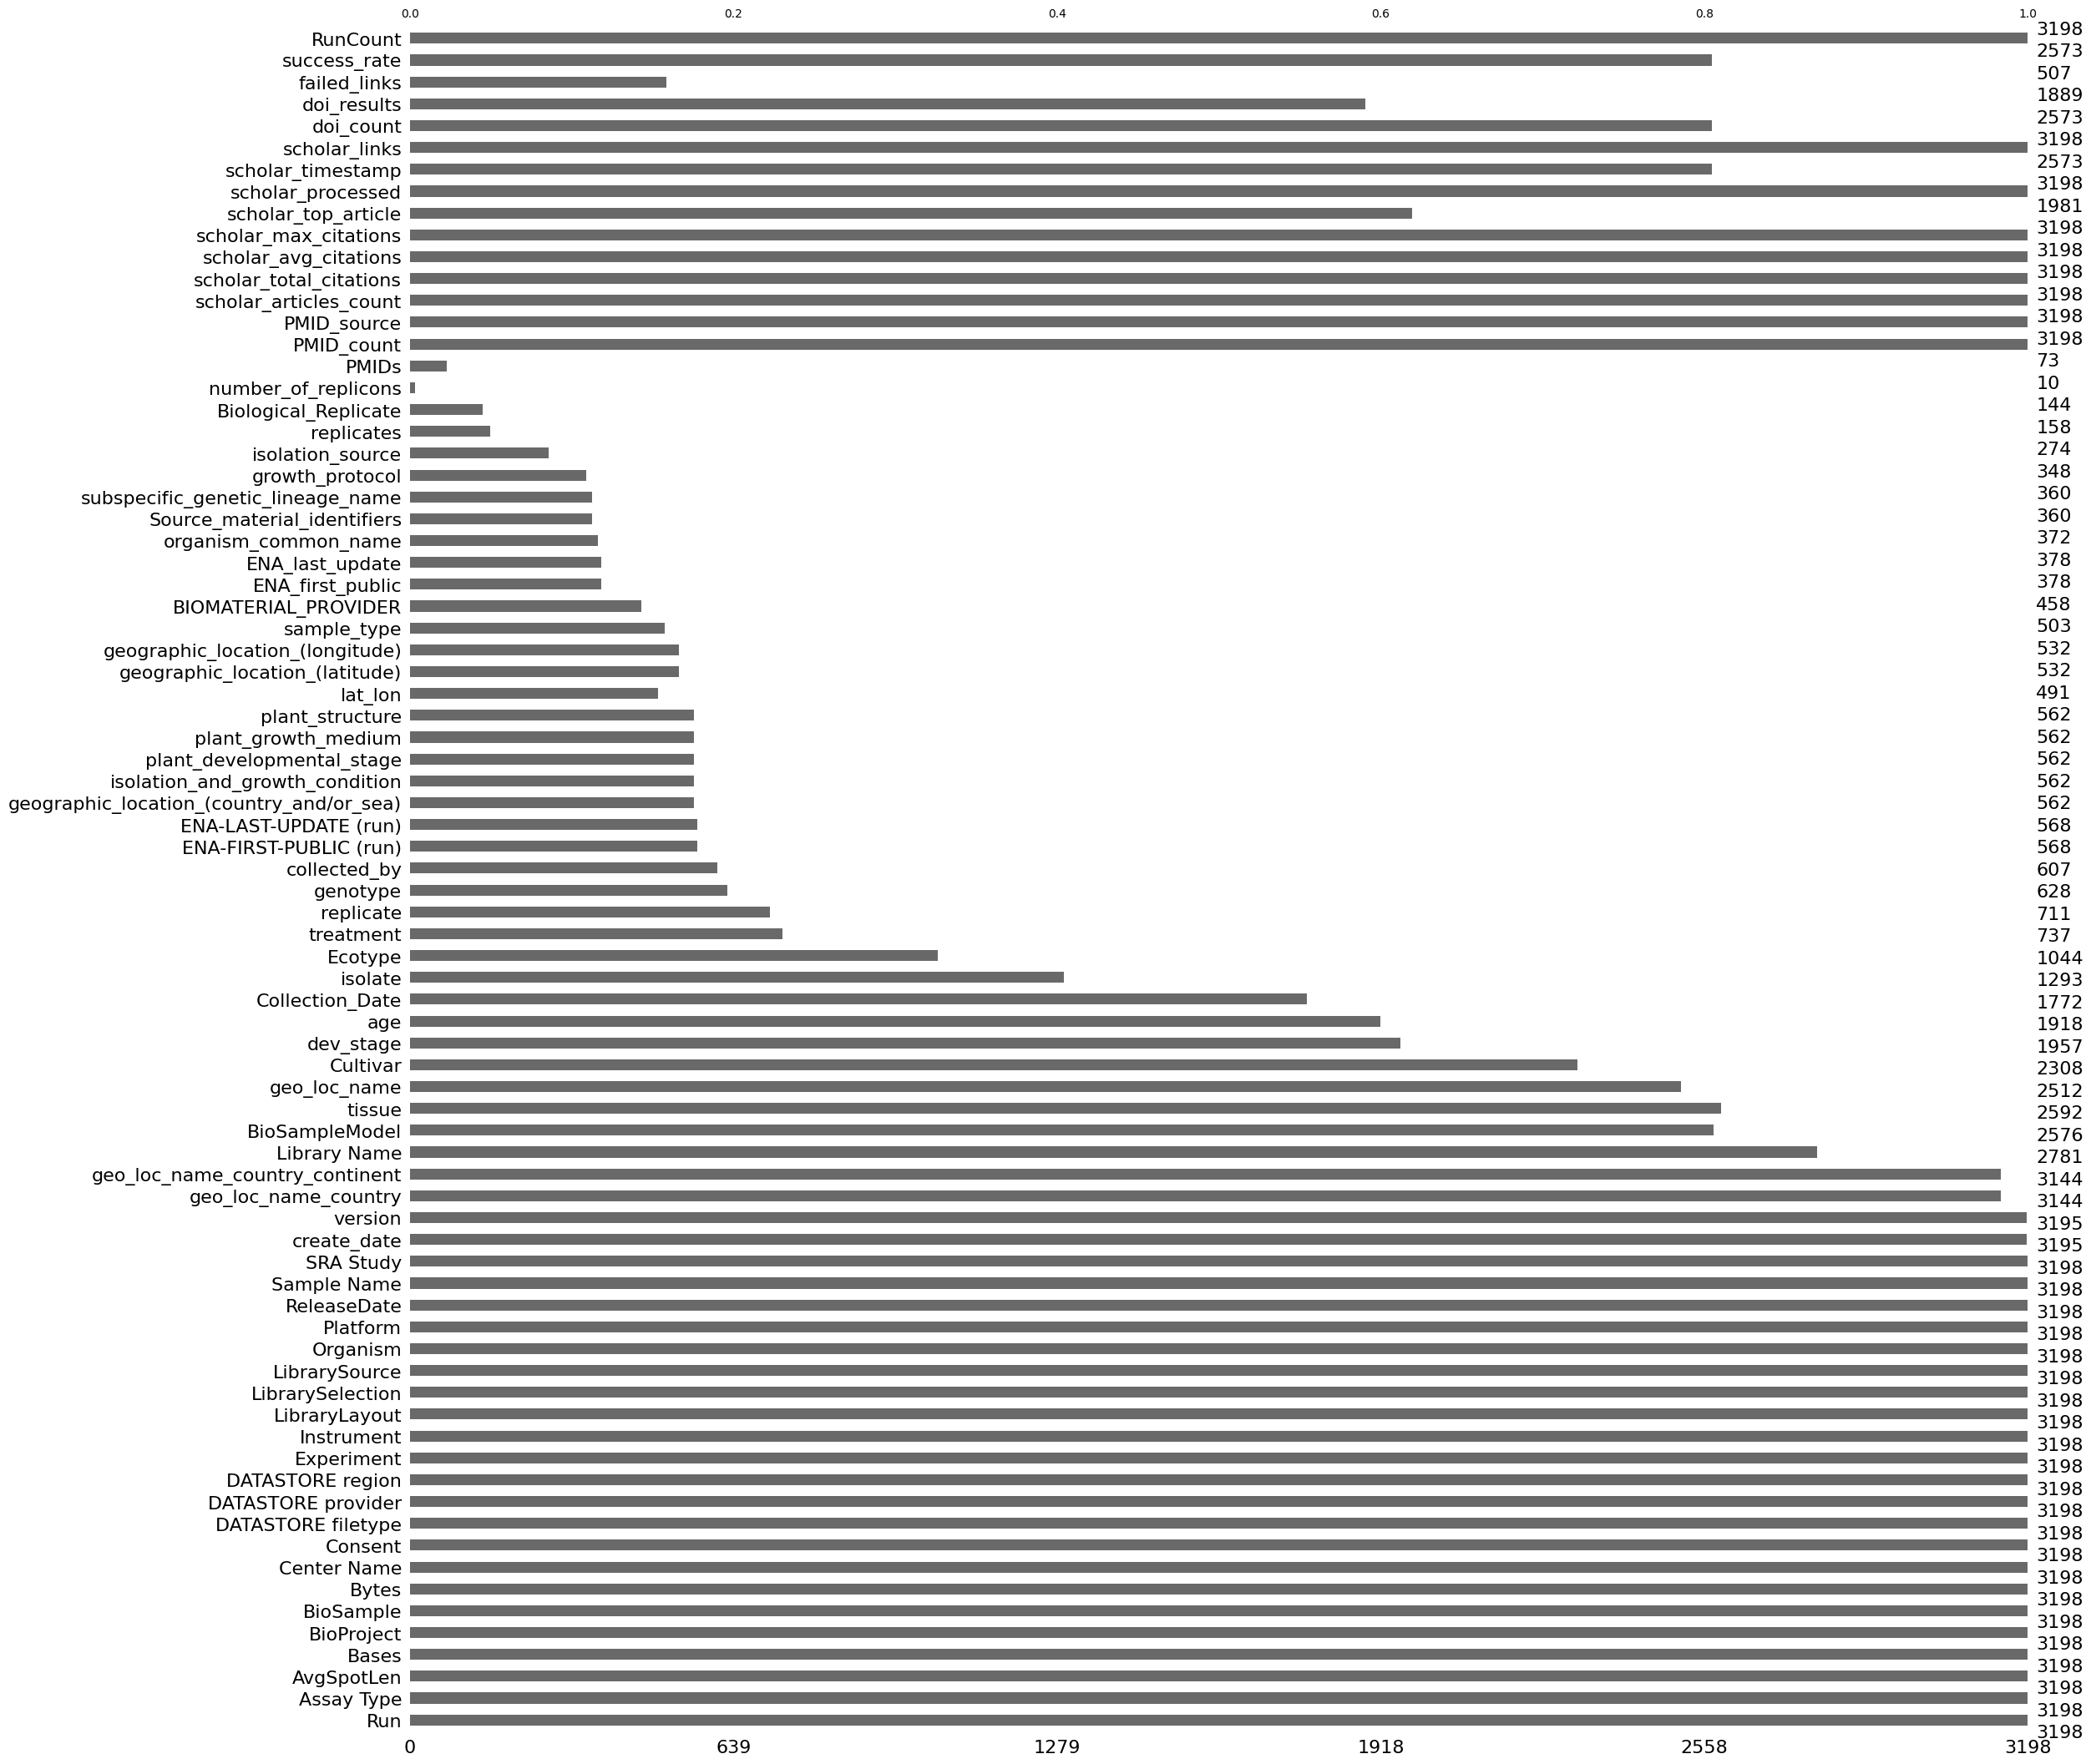

In [93]:
msno.bar(sugarcane_rna_df)

In [94]:
# Verify the cultivars present in the dataset
print(sugarcane_rna_df['Organism'].value_counts())

Organism
Saccharum hybrid cultivar                       1550
Saccharum officinarum                            608
Saccharum spontaneum                             220
Saccharum hybrid cultivar SP80-3280              186
Saccharum officinarum x Saccharum spontaneum     129
Acer saccharum                                   117
Saccharum                                        109
Saccharum hybrid cultivar R570                    37
Saccharum hybrid cultivar F36-819                 37
Saccharum hybrid cultivar ROC22                   36
Saccharum hybrid cultivar CP88-1762               30
rhizosphere metagenome                            24
Tripidium arundinaceum                            18
Saccharum hybrid cultivar FN15                    18
Picea glauca                                      16
Sorghum bicolor                                   12
Saccharum hybrid cultivar RB867515                12
Telchin licus                                      7
Saccharum hybrid cultivar Co 86032   

In [95]:
# Remove rows with non sugarcane organism entries (based in the previous output)
non_sugarcane_values = ['Acer saccharum', 'rhizosphere metagenome', 'Picea glauca', 'Sorghum bicolor', 'Telchin licus', 'Burkholderia seminalis', 'plant metagenome']
sugarcane_rna_df = sugarcane_rna_df[~sugarcane_rna_df['Organism'].isin(non_sugarcane_values)]
print(sugarcane_rna_df['Organism'].value_counts())

Organism
Saccharum hybrid cultivar                       1550
Saccharum officinarum                            608
Saccharum spontaneum                             220
Saccharum hybrid cultivar SP80-3280              186
Saccharum officinarum x Saccharum spontaneum     129
Saccharum                                        109
Saccharum hybrid cultivar R570                    37
Saccharum hybrid cultivar F36-819                 37
Saccharum hybrid cultivar ROC22                   36
Saccharum hybrid cultivar CP88-1762               30
Saccharum hybrid cultivar FN15                    18
Tripidium arundinaceum                            18
Saccharum hybrid cultivar RB867515                12
Saccharum hybrid cultivar Co 86032                 7
Saccharum robustum                                 6
Saccharum hybrid cultivar GT11                     5
Saccharum hybrid cultivar CP72-2086                5
Name: count, dtype: int64


In [96]:
sugarcane_rna_df.shape

(3013, 78)

#### Creating the dataframe with only relevant columns

In [97]:
sugarcane_rna_df.columns

Index(['Run', 'Assay Type', 'AvgSpotLen', 'Bases', 'BioProject', 'BioSample',
       'Bytes', 'Center Name', 'Consent', 'DATASTORE filetype',
       'DATASTORE provider', 'DATASTORE region', 'Experiment', 'Instrument',
       'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'Organism',
       'Platform', 'ReleaseDate', 'Sample Name', 'SRA Study', 'create_date',
       'version', 'geo_loc_name_country', 'geo_loc_name_country_continent',
       'Library Name', 'BioSampleModel', 'tissue', 'geo_loc_name', 'Cultivar',
       'dev_stage', 'age', 'Collection_Date', 'isolate', 'Ecotype',
       'treatment', 'replicate', 'genotype', 'collected_by',
       'ENA-FIRST-PUBLIC (run)', 'ENA-LAST-UPDATE (run)',
       'geographic_location_(country_and/or_sea)',
       'isolation_and_growth_condition', 'plant_developmental_stage',
       'plant_growth_medium', 'plant_structure', 'lat_lon',
       'geographic_location_(latitude)', 'geographic_location_(longitude)',
       'sample_type', 'BIOMATERI

In [98]:
# Select the columns
columns = ['Run', 'Assay Type', 'AvgSpotLen', 'Bases', 'BioProject', 'BioSample',
       'Bytes', 'Center Name', 'Consent', 'DATASTORE filetype',
       'DATASTORE provider', 'DATASTORE region', 'Experiment', 'Instrument',
       'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'Organism',
       'Platform', 'ReleaseDate', 'Sample Name', 'SRA Study', 'create_date',
       'version', 'BioSampleModel',  'Collection_Date', 'doi_results', 'PMIDs', 'RunCount']
 
new_columns = ['geo_location', 'growth_conditions', 'sample_conditions', 'genotype', 'replicate']
# Create a dataframe with only relevant columns
sugarcane_rna_df_relevant = sugarcane_rna_df[columns]

In [99]:
cols_repl = [
    'replicates',
    'Biological_Replicate',
    'number_of_replicons',
    'replicate',
    
]

# cria nova coluna concatenando valores não nulos separados por "| "
sugarcane_rna_df_relevant = sugarcane_rna_df_relevant.copy()

sugarcane_rna_df_relevant.loc[:, 'replicate'] = (
    sugarcane_rna_df[cols_repl]
    .astype(str)
    .replace(['nan', 'None', 'NaN'], '')
    .agg('| '.join, axis=1)
    .str.strip('| ')
    .str.replace(r'\s*\|\s*$', '', regex=True)
)

sugarcane_rna_df_relevant.loc[:, 'replicate'] = (
    sugarcane_rna_df_relevant['replicate']
    .replace('', pd.NA)
)

In [100]:
cols_geo = [
    'lat_lon',
    'geographic_location_(latitude)',
    'geographic_location_(longitude)',
    'geo_loc_name',
    'geo_loc_name_country',
    'geo_loc_name_country_continent',
]

# cria nova coluna concatenando valores não nulos separados por "| "
sugarcane_rna_df_relevant = sugarcane_rna_df_relevant.copy()

sugarcane_rna_df_relevant.loc[:, 'geo_location'] = (
    sugarcane_rna_df[cols_geo]
    .astype(str)
    .replace(['nan', 'None', 'NaN'], '')
    .agg('| '.join, axis=1)
    .str.strip('| ')
    .str.replace(r'\s*\|\s*$', '', regex=True)
)

sugarcane_rna_df_relevant.loc[:, 'geo_location'] = (
    sugarcane_rna_df_relevant['geo_location']
    .replace('', pd.NA)
)

In [101]:
cols_cndt = [
    'isolation_and_growth_condition',
    'plant_growth_medium',
    'growth_protocol'
]

# cria nova coluna concatenando valores não nulos separados por "| "
sugarcane_rna_df_relevant = sugarcane_rna_df_relevant.copy()

sugarcane_rna_df_relevant.loc[:, 'growth_conditions'] = (
    sugarcane_rna_df[cols_cndt]
    .astype(str)
    .replace(['nan', 'None', 'NaN'], '')
    .agg('| '.join, axis=1)
    .str.strip('| ')
    .str.replace(r'\s*\|\s*$', '', regex=True)
)

sugarcane_rna_df_relevant.loc[:, 'growth_conditions'] = (
    sugarcane_rna_df_relevant['growth_conditions']
    .replace('', pd.NA)
)

In [102]:
sugarcane_rna_df_relevant.head(3)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,...,create_date,version,BioSampleModel,Collection_Date,doi_results,PMIDs,RunCount,replicate,geo_location,growth_conditions
0,ERR5880619,RNA-Seq,202,7173776894,PRJEB44480,SAMEA8663682,2028601309,UNIVERSITY OF QUEENSLAND,public,"fastq,run.zq,sra",...,2022-07-18T12:25:00Z,1.0,NaN,2018-01,"[{""link"": ""https://www.nature.com/articles/s41...",NaN,360,<NA>,19?34'08.0S| 147?19'30.7E| | Australia| Oceania,Field| Field
1,ERR5880620,RNA-Seq,202,6820275682,PRJEB44480,SAMEA8663683,1930474199,UNIVERSITY OF QUEENSLAND,public,"fastq,run.zq,sra",...,2022-07-20T16:00:00Z,1.0,NaN,2018-01,"[{""link"": ""https://www.nature.com/articles/s41...",NaN,360,<NA>,19?34'08.0S| 147?19'30.7E| | Australia| Oceania,Field| Field
2,ERR5880736,RNA-Seq,202,6692273938,PRJEB44480,SAMEA8659510,1909939693,UNIVERSITY OF QUEENSLAND,public,"fastq,run.zq,sra",...,2022-07-25T18:43:00Z,1.0,NaN,2018-01,"[{""link"": ""https://www.nature.com/articles/s41...",NaN,360,<NA>,19D34'08.0''S| 147D19'30.7''E| | Australia| Oc...,Field| Field


In [103]:
cols_treatm = [
    'treatment', 'tissue', 'dev_stage', 'age', 'isolate', 'plant_structure', 'plant_developmental_stage', 'isolation_source']

# cria nova coluna concatenando valores não nulos separados por "| "
sugarcane_rna_df_relevant = sugarcane_rna_df_relevant.copy()

sugarcane_rna_df_relevant.loc[:, 'sample_conditions'] = (
    sugarcane_rna_df[cols_treatm]
    .astype(str)
    .replace(['nan', 'None', 'NaN'], '')
    .agg('| '.join, axis=1)
    .str.strip('| ')
    .str.replace(r'\s*\|\s*$', '', regex=True)
)

sugarcane_rna_df_relevant.loc[:, 'sample_conditions'] = (
    sugarcane_rna_df_relevant['sample_conditions']
    .replace('', pd.NA)
)

In [104]:
sugarcane_rna_df_relevant.head(3)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,...,version,BioSampleModel,Collection_Date,doi_results,PMIDs,RunCount,replicate,geo_location,growth_conditions,sample_conditions
0,ERR5880619,RNA-Seq,202,7173776894,PRJEB44480,SAMEA8663682,2028601309,UNIVERSITY OF QUEENSLAND,public,"fastq,run.zq,sra",...,1.0,NaN,2018-01,"[{""link"": ""https://www.nature.com/articles/s41...",NaN,360,<NA>,19?34'08.0S| 147?19'30.7E| | Australia| Oceania,Field| Field,Culm| Internode 8
1,ERR5880620,RNA-Seq,202,6820275682,PRJEB44480,SAMEA8663683,1930474199,UNIVERSITY OF QUEENSLAND,public,"fastq,run.zq,sra",...,1.0,NaN,2018-01,"[{""link"": ""https://www.nature.com/articles/s41...",NaN,360,<NA>,19?34'08.0S| 147?19'30.7E| | Australia| Oceania,Field| Field,Culm| Internode 5
2,ERR5880736,RNA-Seq,202,6692273938,PRJEB44480,SAMEA8659510,1909939693,UNIVERSITY OF QUEENSLAND,public,"fastq,run.zq,sra",...,1.0,NaN,2018-01,"[{""link"": ""https://www.nature.com/articles/s41...",NaN,360,<NA>,19D34'08.0''S| 147D19'30.7''E| | Australia| Oc...,Field| Field,Culm| Internode 8


In [105]:
cols_genotype = ['genotype', 'Cultivar', 'subspecific_genetic_lineage_name']

# cria nova coluna concatenando valores não nulos separados por "| "
sugarcane_rna_df_relevant = sugarcane_rna_df_relevant.copy()

sugarcane_rna_df_relevant.loc[:, 'genotype'] = (
    sugarcane_rna_df[cols_genotype]
    .astype(str)
    .replace(['nan', 'None', 'NaN'], '')
    .agg('| '.join, axis=1)
    .str.strip('| ')
    .str.replace(r'\s*\|\s*$', '', regex=True)
)

sugarcane_rna_df_relevant.loc[:, 'genotype'] = (
    sugarcane_rna_df_relevant['genotype']
    .replace('', pd.NA)
)

In [106]:
sugarcane_rna_df_relevant.head(3)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,...,BioSampleModel,Collection_Date,doi_results,PMIDs,RunCount,replicate,geo_location,growth_conditions,sample_conditions,genotype
0,ERR5880619,RNA-Seq,202,7173776894,PRJEB44480,SAMEA8663682,2028601309,UNIVERSITY OF QUEENSLAND,public,"fastq,run.zq,sra",...,NaN,2018-01,"[{""link"": ""https://www.nature.com/articles/s41...",NaN,360,<NA>,19?34'08.0S| 147?19'30.7E| | Australia| Oceania,Field| Field,Culm| Internode 8,Q135
1,ERR5880620,RNA-Seq,202,6820275682,PRJEB44480,SAMEA8663683,1930474199,UNIVERSITY OF QUEENSLAND,public,"fastq,run.zq,sra",...,NaN,2018-01,"[{""link"": ""https://www.nature.com/articles/s41...",NaN,360,<NA>,19?34'08.0S| 147?19'30.7E| | Australia| Oceania,Field| Field,Culm| Internode 5,Q253
2,ERR5880736,RNA-Seq,202,6692273938,PRJEB44480,SAMEA8659510,1909939693,UNIVERSITY OF QUEENSLAND,public,"fastq,run.zq,sra",...,NaN,2018-01,"[{""link"": ""https://www.nature.com/articles/s41...",NaN,360,<NA>,19D34'08.0''S| 147D19'30.7''E| | Australia| Oc...,Field| Field,Culm| Internode 8,SRA2


<Axes: >

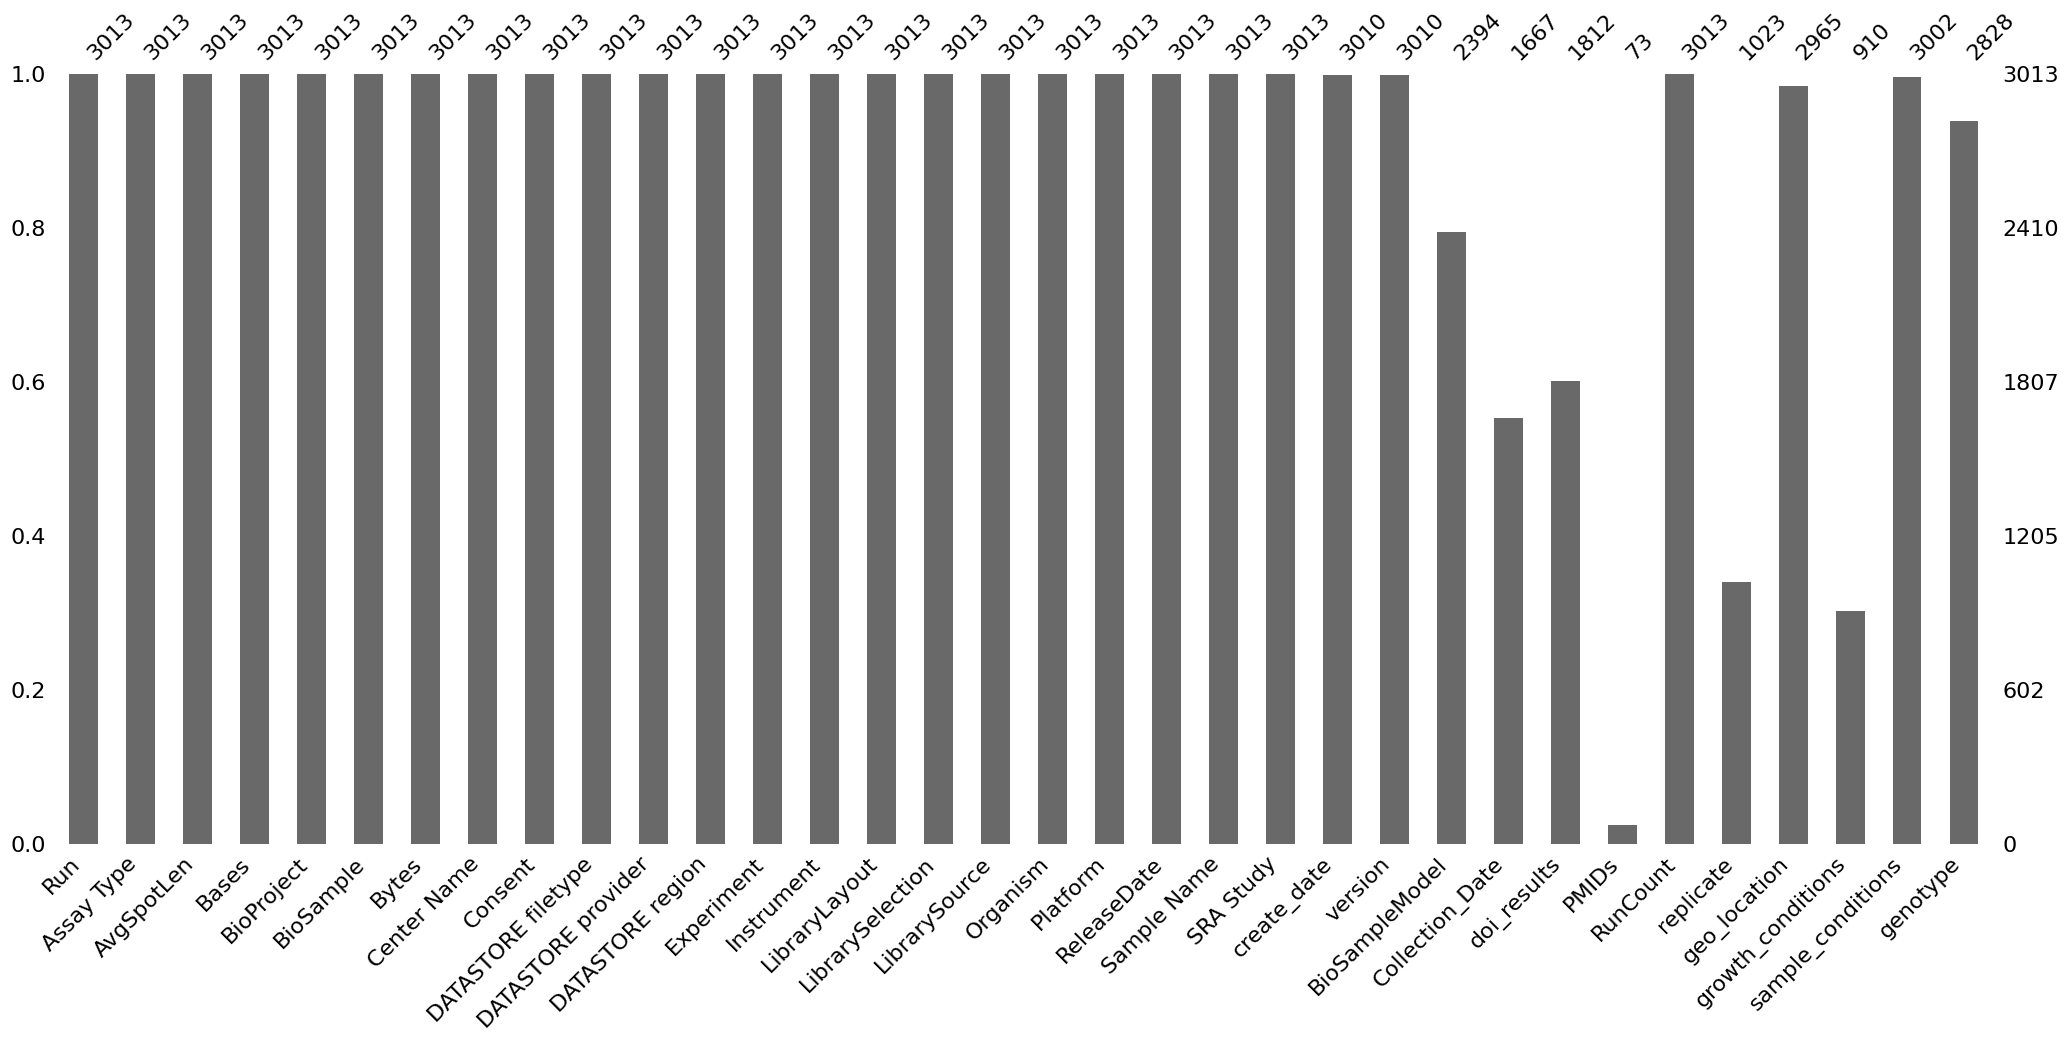

In [107]:
msno.bar(sugarcane_rna_df_relevant)

In [108]:
sugarcane_rna_df_relevant['geo_location'].value_counts()

geo_location
19?34'08.0S| 147?19'30.7E| | Australia| Oceania                                                                                       349
Brazil: Araras\, SP| Brazil| South America                                                                                            240
China:Fuzhou| China| Asia                                                                                                             231
China| China| Asia                                                                                                                    161
-22.3161| -47.3901| | Brazil| South America                                                                                           156
19.661167 S 147.466667 E| | | Australia: Burdekin region\, Queensland| Australia| Oceania                                             150
China:Nanning| China| Asia                                                                                                            130
China: Nanning| China

In [109]:
for col in ['geo_location', 'growth_conditions', 'sample_conditions', 'genotype', 'replicate']:
    sugarcane_rna_df_relevant[f'{col}_missing'] = sugarcane_rna_df_relevant[col].apply(has_missing_value)

In [110]:
sugarcane_rna_df_relevant.to_csv('../data/sugarcane_rna_relevant_filtered.csv', index=False)